In [1]:
from robot_utils.robot_data.img_data import ImgData
import matplotlib.pyplot as plt
import cv2 as cv
import math

In [70]:
bag = "/home/masonbp/data/west_point_2023/1117_03_loc_tower_loop_far_side_loop_o3_CW/align.bag"
topic = "/acl_jackal2/forward/color/image_raw/compressed"
topic_t0 = ImgData.topic_t0(bag, topic)

img_data = ImgData(
    data_file=bag,
    file_type='bag',
    topic=topic,
    time_tol=.05,
    t0=0,
    time_range=[topic_t0+200, topic_t0+240]
)

<Axes: >

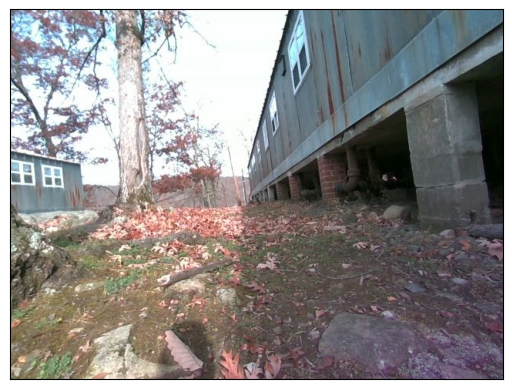

In [3]:
img_data.show(0)

In [4]:
def ssc(keypoints, num_ret_points, tolerance, cols, rows):
    exp1 = rows + cols + 2 * num_ret_points
    exp2 = (
        4 * cols
        + 4 * num_ret_points
        + 4 * rows * num_ret_points
        + rows * rows
        + cols * cols
        - 2 * rows * cols
        + 4 * rows * cols * num_ret_points
    )
    exp3 = math.sqrt(exp2)
    exp4 = num_ret_points - 1

    sol1 = -round(float(exp1 + exp3) / exp4)  # first solution
    sol2 = -round(float(exp1 - exp3) / exp4)  # second solution

    high = (
        sol1 if (sol1 > sol2) else sol2
    )  # binary search range initialization with positive solution
    low = math.floor(math.sqrt(len(keypoints) / num_ret_points))

    prev_width = -1
    selected_keypoints = []
    result_list = []
    result = []
    complete = False
    k = num_ret_points
    k_min = round(k - (k * tolerance))
    k_max = round(k + (k * tolerance))

    while not complete:
        width = low + (high - low) / 2
        if (
            width == prev_width or low > high
        ):  # needed to reassure the same radius is not repeated again
            result_list = result  # return the keypoints from the previous iteration
            break

        c = width / 2  # initializing Grid
        num_cell_cols = int(math.floor(cols / c))
        num_cell_rows = int(math.floor(rows / c))
        covered_vec = [
            [False for _ in range(num_cell_cols + 1)] for _ in range(num_cell_rows + 1)
        ]
        result = []

        for i in range(len(keypoints)):
            row = int(
                math.floor(keypoints[i].pt[1] / c)
            )  # get position of the cell current point is located at
            col = int(math.floor(keypoints[i].pt[0] / c))
            if not covered_vec[row][col]:  # if the cell is not covered
                result.append(i)
                # get range which current radius is covering
                row_min = int(
                    (row - math.floor(width / c))
                    if ((row - math.floor(width / c)) >= 0)
                    else 0
                )
                row_max = int(
                    (row + math.floor(width / c))
                    if ((row + math.floor(width / c)) <= num_cell_rows)
                    else num_cell_rows
                )
                col_min = int(
                    (col - math.floor(width / c))
                    if ((col - math.floor(width / c)) >= 0)
                    else 0
                )
                col_max = int(
                    (col + math.floor(width / c))
                    if ((col + math.floor(width / c)) <= num_cell_cols)
                    else num_cell_cols
                )
                for row_to_cover in range(row_min, row_max + 1):
                    for col_to_cover in range(col_min, col_max + 1):
                        if not covered_vec[row_to_cover][col_to_cover]:
                            # cover cells within the square bounding box with width w
                            covered_vec[row_to_cover][col_to_cover] = True

        if k_min <= len(result) <= k_max:  # solution found
            result_list = result
            complete = True
        elif len(result) < k_min:
            high = width - 1  # update binary search range
        else:
            low = width + 1
        prev_width = width

    for i in range(len(result_list)):
        selected_keypoints.append(keypoints[result_list[i]])

    return selected_keypoints

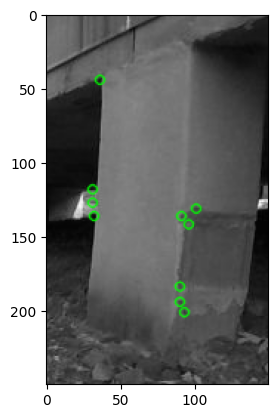

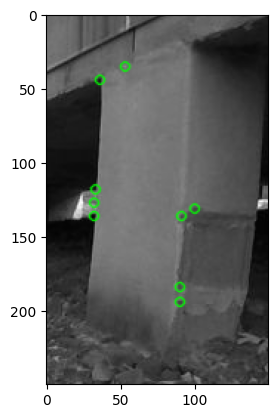

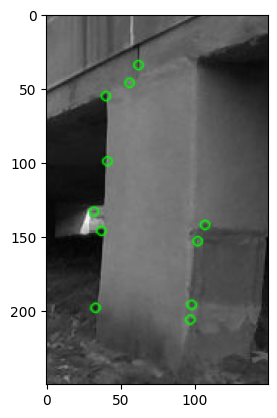

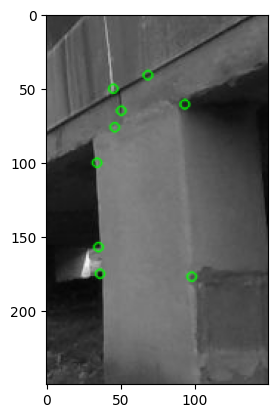

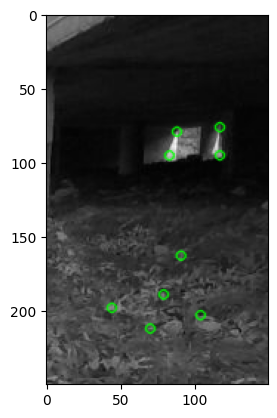

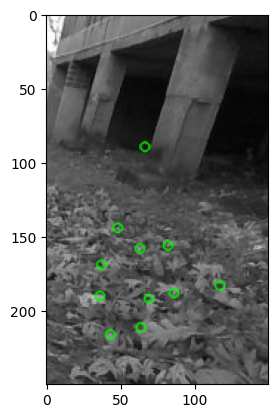

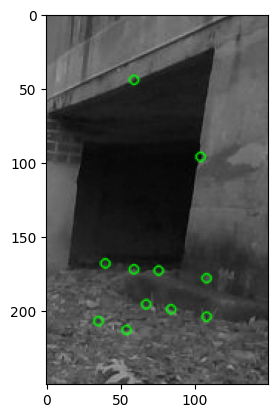

In [107]:
# https://www.geeksforgeeks.org/feature-matching-using-orb-algorithm-in-python-opencv/

features = []
imgs = []

SSC = True

for t in [15, 15.2, 18.8, 19.0, 20.0, 22.0, 28.0]:
    # img = img_data.img(15)
    img = img_data.img(t)[100:350, 450:600,:]
    imgs.append(img)

    # convert to grayscale
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # Initiate ORB detector
    orb = cv.ORB_create(nfeatures=200 if SSC else 50)
    
    # find the keypoints with ORB
    kp = orb.detect(img, None)
    
    # compute the descriptors with ORB
    kp, des = orb.compute(img, kp)

    # keypoints should be sorted by strength in descending order
    # before feeding to SSC to work correctly
    kp = sorted(kp, key=lambda x: x.response, reverse=True)

    if SSC:
        kp_sel = ssc(
            kp, 10, .1, img.shape[1], img.shape[0]
        )
        kp_sel, des = orb.compute(img, kp_sel)
    else:
        kp_sel = kp
    features.append((kp_sel, des))
    
    # draw only keypoints location,not size and orientation
    img2 = cv.drawKeypoints(img, kp_sel, None, color=(0,255,0), flags=0)
    plt.imshow(img2), plt.show()

8


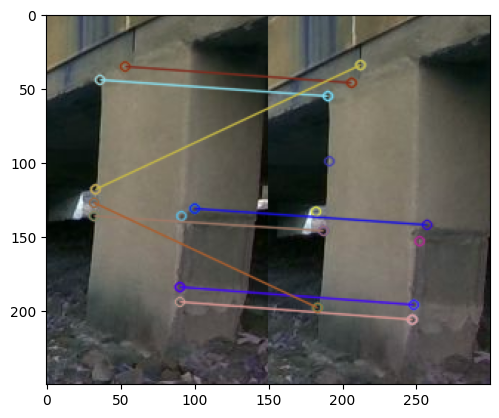

In [113]:
idx1 = 1
idx2 = 2

matcher = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
# matcher = cv.BFMatcher()
matches = matcher.match(features[idx1][1], features[idx2][1])
good_matches = []

matches = sorted(matches, key = lambda x:x.distance)
print(len(matches))
# for m, n in matches:
#     if m.distance < .75*n.distance:
#         good_matches.append([m])

final_img = cv.drawMatches(imgs[idx1], features[idx1][0],  
imgs[idx2], features[idx2][0], matches,None) 
   
# final_img = cv2.resize(final_img, (1000,650)) 
  
# Show the final image 
plt.imshow(final_img)
# cv2.waitKey(3000) 

6


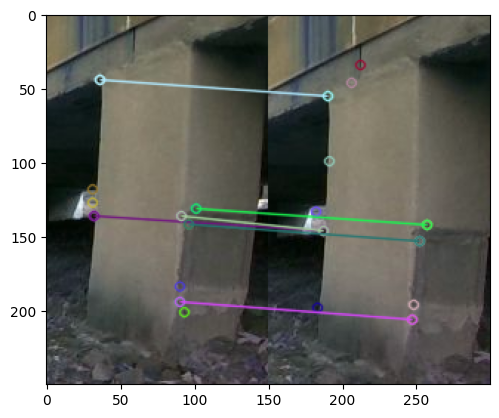

In [114]:
idx1 = 0
idx2 = 2

matcher = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=False)
# matcher = cv.BFMatcher()
matches = matcher.knnMatch(features[idx1][1], features[idx2][1], k=2)


good_matches = []
for m, n in matches:
    if m.distance < .75*n.distance:
        good_matches.append(m)
print(len(good_matches))

final_img = cv.drawMatches(imgs[idx1], features[idx1][0],  
imgs[idx2], features[idx2][0], good_matches,None) 
   
# final_img = cv2.resize(final_img, (1000,650)) 
  
# Show the final image 
plt.imshow(final_img)
# cv2.waitKey(3000) 